In [1]:
#####Variable order Tensor Decomposition#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import gc
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z

In [3]:
####データの発生####
##データの設定
#要素ごとのユニーク数を設定
k = 10
hh = 5000
item = 2500
subject = 700
element = 500
max_m = 8

#要素ごとの頻度を生成
pt = np.random.poisson(np.random.gamma(15, 1/0.1, hh))
N = np.sum(pt)
m = np.random.poisson(2.5, N)
m[m==0] = 1; m[m >= max_m] = max_m
M = np.sum(m)

In [4]:
##idとインデックスの設定
#idの設定
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))
m_id = np.repeat(np.arange(N), m)

#インデックスの設定
freq_m = np.repeat(0, hh)
d_index = [i for i in range(hh)]
m_index = [i for i in range(N)]
for i in range(hh):
    d_index[i] = np.array(np.where(d_id==i)[0], dtype="int")
    freq_m[i] = np.sum(m[d_index[i]])
for i in range(N):
    if i==0:
        m_index[i] = np.arange(m[0])
    else:
        m_index[i] = np.max(m_index[i-1]) + np.arange(m[i]) + 1
freq_id = np.repeat(np.arange(hh), freq_m)

In [6]:
##アイテムの生成
#多項分布からトピックを生成
topic = 25
theta = np.random.dirichlet(np.repeat(0.2, topic), hh)
z = np.array(rmnom(theta[freq_id, ], M, topic, np.arange(M), 0), dtype="int")

#アイテムの生成確率を設定
phi_item = np.random.dirichlet(np.repeat(0.1, item), topic)
phi_subject = np.random.dirichlet(np.repeat(0.1, subject), topic)
phi_element = np.random.dirichlet(np.repeat(0.1, element), topic)

#トピックからアイテムを生成
item_long = np.repeat(0, M)
for j in range(topic):
    index = np.array(np.where(z==j)[0], dtype="int")
    topic_n = index.shape[0]
    item_long[index] = np.array(rmnom(phi_item[z[index], ], topic_n, item, np.arange(topic_n), 0), dtype="int")
subject_long = np.array(rmnom(phi_subject[z, ], M, subject, np.arange(M), 0), dtype="int")
element_long = np.array(rmnom(phi_element[z, ], M, element, np.arange(M), 0), dtype="int")
gc.collect()

#アイテムをレコードに割当
item_dt = np.full((N, max_m), item, dtype="int16")
subject_dt = np.full((N, max_m), subject, dtype="int16")
element_dt = np.full((N, max_m), element, dtype="int16")
for i in range(N):
    item_dt[i, np.arange(m[i])] = item_long[m_index[i]]
    subject_dt[i, np.arange(m[i])] = subject_long[m_index[i]]
    element_dt[i, np.arange(m[i])] = element_long[m_index[i]]
    
#一定確率で欠損を挿入
subject_dt[np.random.binomial(1, 0.5, N*max_m).reshape(N, max_m)==1] = subject
element_dt[np.random.binomial(1, 0.3, N*max_m).reshape(N, max_m)==1] = element

#観測インデックスを作成
z_index = [j for j in range(max_m)]
item_z = [j for j in range(max_m)]
subject_z = [j for j in range(max_m)]
element_z = [j for j in range(max_m)]
for j in range(max_m):
    z_index[j] = np.array(np.where(item_dt[:, j]!=item)[0], dtype="int")
    item_z[j] = item_dt[z_index[j], j]
    subject_z[j] = subject_dt[z_index[j], j]
    element_z[j] = element_dt[z_index[j], j]

In [7]:
##応答変数を生成
per_min = 75; per_max = 75
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    #事前分布のパラメータを設定
    alpha1 = np.array([0])
    alpha2 = np.repeat(0, k)
    tau_d = np.array([0.7])
    Cov_d = np.diag(np.repeat(0.55, k))
    Cov_i = np.diag(np.repeat(0.55, k))
    Cov_s = np.diag(np.repeat(0.3, k))
    Cov_e = np.diag(np.repeat(0.3, k))
    alphat1 = alpha1.copy(); alphat2 = alpha2.copy()
    taut_d = tau_d.copy()
    Covt_d = Cov_d.copy(); Covt_i = Cov_i.copy(); Covt_s = Cov_s.copy(); Covt_e = Cov_e.copy()

    #モデルパラメータを生成
    Sigma = np.array([0.2])
    beta = np.array([5.5])
    beta_d = np.random.normal(alpha1, tau_d, hh)
    theta_d = np.random.multivariate_normal(alpha2, Cov_d, hh)
    theta_i = np.vstack((np.random.multivariate_normal(alpha2, Cov_i, item), np.repeat(1, k)))
    theta_s = np.vstack((np.random.multivariate_normal(alpha2, Cov_s, subject), np.repeat(1, k)))
    theta_e = np.vstack((np.random.multivariate_normal(alpha2, Cov_e, element), np.repeat(1, k)))
    Sigmat = Sigma.copy(); betat = beta.copy(); betat_d = beta_d.copy()
    thetat_d = theta_d.copy(); thetat_i = theta_i.copy(); thetat_s = theta_s.copy(); thetat_e = theta_e.copy()

    #期待値を設定
    joint_theta = np.zeros((N, k))
    for j in range(max_m):
        index = z_index[j]
        joint_theta[index, ] += theta_i[item_z[j], ] * theta_s[subject_z[j], ] * theta_e[element_z[j], ]
    uv = np.dot(theta_d[d_id, ] * joint_theta, np.repeat(1, k))
    mu = beta + beta_d[d_id, ] + uv

    #正規分布から応答変数を生成
    y_full = mu + np.random.normal(0, Sigma, N)

    #応答変数のbreak条件
    if (np.mean(y_full) > 5.0) & (np.mean(y_full) < 6.0) & (np.sum(y_full <= 0) < N/per_min) & (np.sum(y_full > 10) < N/per_max):
        print(np.sum((y_full > 10) | (y_full < 0)))
        print("ok")
        break

1
12291
ok


In [8]:
#生成したスコアを評価データに変換
y = y_full.copy()
y = np.array(np.round(y), dtype="int")
y[y < 0] = 0; y[y >= 10] = 10

#生成したデータの確認
print(np.round(np.array([np.mean(y_full), np.mean(y)]), 3))
print(np.round(np.array([np.std(y_full), np.std(y)]), 3))

[5.48  5.473]
[1.757 1.717]


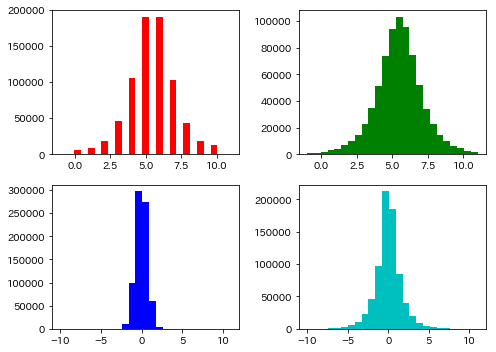

In [9]:
#潜在変数ごとのヒストグラム
dt = [y, mu, beta_d[d_id, ], uv]
fig_range = np.append(np.array([-1.0, -1.0, -10, -10]), np.repeat(11.0, len(dt))).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig = plt.figure(figsize=(7.0, 5.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
fig.tight_layout()
plt.show()

In [ ]:
##テストデータの作成

In [ ]:
####マルコフ連鎖モンテカルロ法でVoTDを推定####
R = 2000
keep = 10
burnin = int(500/keep)
iter = 0
disp = 4
e1 = 0.001
e2 = 0.001
L = 3

In [145]:
##観測レコードと観測データをインデックスで対応付ける
#areaのインデックスを作成
area_list = [i for i in range(area)]
area_freq = np.repeat(0, area)
for i in range(area):
    area_list[i] = np.array(np.where(np.in1d(pt_id, np.unique(m_id[area_index[i]]))==True)[0], dtype="int")
    area_freq[i] = area_list[i].shape[0]
    
#itemのインデックスを作成
item_list = [i for i in range(item)]
item_freq = np.repeat(0, item)
for i in range(item):
    item_list[i] = np.array(np.where(np.in1d(pt_id, np.unique(m_id[item_index[i]]))==True)[0], dtype="int")
    item_freq[i] = item_list[i].shape[0]
    
#subjectのインデックスを作成
subject_list = [i for i in range(subject)]
subject_freq = np.repeat(0, subject)
for i in range(subject):
    subject_list[i] = np.array(np.where(np.in1d(pt_id, np.unique(m_id[subject_index[i]]))==True)[0], dtype="int")
    subject_freq[i] = subject_list[i].shape[0]
    
#elementのインデックスを作成
element_list = [i for i in range(subject)]
element_freq = np.repeat(0, subject)
for i in range(element):
    element_list[i] = np.array(np.where(np.in1d(pt_id, np.unique(m_id[element_index[i]]))==True)[0], dtype="int")
    element_freq[i] = element_list[i].shape[0]
    
#trendのインデックスを作成
trend_list = [i for i in range(trend)]
trend_freq = np.repeat(0, trend)
for i in range(trend):
    trend_list[i] = np.array(np.where(np.in1d(pt_id, np.unique(m_id[trend_index[i]]))==True)[0], dtype="int")
    trend_freq[i] = trend_list[i].shape[0]
    
#リストに格納
allocation_list = [area_list, item_list, subject_list, element_list, trend_list]
allocation_freq = [area_freq, item_freq, subject_freq, element_freq, trend_freq]
n = [area, item, subject, element, trend]
del area_list, item_list, subject_list, element_list, trend_list

In [146]:
##事前分布の設定
#階層モデルの事前分布
gamma = np.array([0])
delta = np.repeat(0, k)
nu = 1
V = 0.1 * np.diag(np.ones(k))
s01 = 0.1
s01 = 0.1

#モデルパラメータの事前分布
tau = 100 
s02 = 1.0
v02 = 1.0

In [382]:
##パラメータの真値
#階層モデルの事前分布の真値
alpha1 = alphat1.copy()
alpha2 = alphat2.copy()
tau_c = taut_c.copy(); tau_d = taut_d.copy()
Cov_c = Covt_c.copy(); inv_Cov_c = np.linalg.inv(Cov_c)
Cov_a = Covt_a.copy(); inv_Cov_a = np.linalg.inv(Cov_a)
Cov_i = Covt_i.copy(); inv_Cov_i = np.linalg.inv(Cov_i)
Cov_s = Covt_s.copy(); inv_Cov_s = np.linalg.inv(Cov_s)
Cov_e = Covt_e.copy(); inv_Cov_e = np.linalg.inv(Cov_e)
Cov_t = Covt_t.copy(); inv_Cov_t = np.linalg.inv(Cov_t)

#モデルパラメータの真値
Sigma = Sigmat.copy()
beta = betat.copy()
beta_c = betat_c.copy(); beta_d = betat_d.copy()
theta_c = thetat_c.copy()
theta_a = thetat_a.copy()
theta_i = thetat_i.copy()
theta_s = thetat_s.copy()
theta_e = thetat_e.copy()
theta_t = thetat_t.copy()
theta_a = np.random.multivariate_normal(alpha2, Cov_a, area)

#期待値の設定
beta_vec1 = beta_c[company_id]; beta_vec2 = beta_d[pt_id]
theta_prod = theta_a[area_id, ] * theta_i[item_id, ] * theta_s[subject_id, ] * theta_e[element_id, ] * theta_t[trend_id, ]
theta_w = np.zeros((days, k))
for j in range(days):
    theta_w[j, ] = np.sum(theta_prod[m_index[j], ], axis=0)
joint_theta = theta_c[company_id, ] * theta_w[pt_id, ]
uv = np.dot(joint_theta, np.repeat(1, k))
mu = beta + beta_vec1 + beta_vec2 + uv
mut = mu.copy()

In [425]:
#期待値の設定
beta_vec1 = beta_c[company_id]; beta_vec2 = beta_d[pt_id]
theta_prod = theta_a[area_id, ] * theta_i[item_id, ] * theta_s[subject_id, ] * theta_e[element_id, ] * theta_t[trend_id, ]
theta_w = np.zeros((days, k))
for j in range(days):
    theta_w[j, ] = np.sum(theta_prod[m_index[j], ], axis=0)
joint_theta = theta_c[company_id, ] * theta_w[pt_id, ]
uv = np.dot(joint_theta, np.repeat(1, k))
mu = beta + beta_vec1 + beta_vec2 + uv
mut = mu.copy()

TypeError: unsupported operand type(s) for +: 'builtin_function_or_method' and 'float'

In [ ]:
%%time
er_y = y - beta_vec1 - beta_vec2
for i in range(area):
    theta_prod0 = theta_prod.copy()
    theta_prod0[area_index[i], ] = 0
    theta_w0 = np.zeros((days, k))

    for j in range(days):
        theta_w0[j, ] = np.sum(theta_prod0[m_index[j], ], axis=0)
    index = allocation_list[0][i]
    y1 = er_y[index] - np.dot(theta_c[company_id[index], ] * theta_w0[pt_id[index], ], np.repeat(1, k))
    x1 = theta_c[company_id[index], ] * (theta_w[pt_id[index], ] - theta_w0[pt_id[index], ]) / np.full((index.shape[0], k), theta_a[i, ])
    theta_a[i, ] = np.dot(np.dot(np.linalg.inv(np.dot(x1.T, x1)), x1.T), y1)

In [429]:
area_id

array([59, 18, 96, ..., 88, 59, 70])

In [428]:
pt_id.shape

(2209057,)

In [ ]:
i = 0
print(theta_a[i, ])
print(thetat_a[i, ])

In [412]:
%%time
y1 = er_y[index] - np.dot(theta_c[index1, ] * theta_w01[index2, ], np.repeat(1, k))
x1 = (theta_c[index1, ] * theta_w02[index2, ]) / np.full((index.shape[0], k), theta_a[i, ])
np.dot(np.dot(np.linalg.inv(np.dot(x1.T, x1)), x1.T), y1)

Wall time: 218 ms


In [410]:
index1 = company_id[index]
index2 = pt_id[index]

In [401]:
i = 1
print(theta_a[i, ])
print(thetat_a[i, ])

[-0.54324224 -0.28935232  0.27087942  0.4277994  -0.87458613  0.58153539
 -0.13108587  0.81989717  0.32024495  0.60243002]
[-0.5471206  -0.0958197   0.27179598  0.43153228 -0.8746894   0.45576986
 -0.13179825  0.816551    0.32597021  0.59954757]


In [336]:
for i in range(area):
    theta_prod01 = theta_prod.copy(); theta_prod01[area_index[i], ] = 0
    theta_prod02 = np.zeros((M, k)); theta_prod02[area_index[i], ] = theta_prod[area_index[i], ]
    theta_w01 = np.zeros((days, k))
    theta_w02 = np.zeros((days, k))

    for j in range(days):
        theta_w01[j, ] = np.sum(theta_prod01[m_index[j], ], axis=0)
        theta_w02[j, ] = np.sum(theta_prod02[m_index[j], ], axis=0)

    index = allocation_list[0][i]
    y1 = er_y[index] - np.dot(theta_c[company_id[index], ] * theta_w01[pt_id[index], ], np.repeat(1, k))
    x1 = (theta_c[company_id[index], ] * theta_w02[pt_id[index], ]) / np.full((index.shape[0], k), theta_a[i, ])
    theta_a[i, ] = np.dot(np.dot(np.linalg.inv(np.dot(x1.T, x1)), x1.T), y1)

In [337]:
index = allocation_list[0][i]
y1 = er_y[index] - np.dot(theta_c[company_id[index], ] * theta_w0[pt_id[index], ], np.repeat(1, k))
x1 = theta_c[company_id[index], ] * (theta_w[pt_id[index], ] - theta_w0[pt_id[index], ]) / np.full((index.shape[0], k), theta_a[i, ])
np.dot(np.dot(np.linalg.inv(np.dot(x1.T, x1)), x1.T), y1)

array([ 0.52034627, -0.21906398,  0.12976857, -0.13085216,  0.49632034,
        0.14882734, -0.9191929 , -0.8055616 , -0.65877104, -0.27555389])

In [213]:
i = 0
index = allocation_list[0][i]
theta_a0 = area_ones; theta_a0[i, ] = 0
theta_prod0 = theta_a0[area_id, ] * theta_prod
theta_w0 = np.zeros((days, k))
for j in range(days):
    theta_w0[j, ] = np.sum(theta_prod0[m_index[j], ], axis=0)

y1 = er_y[index] - np.sum(theta_w0[pt_id[index], ], axis=1); x1 = joint_theta[index, ] / np.full((allocation_freq[0][i], k), theta_a[i, ])
xy = np.dot(x1.T, y1)
xxv = np.dot(x1.T, x1) + inv_Cov_a
inv_xxv = np.linalg.inv(xxv)
theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_a, alpha2))


In [214]:
theta_par

array([-0.07056159,  0.02953324, -0.04400801, -0.08047879, -0.00876154,
        0.11415773, -0.02632933,  0.01850512, -0.00012239,  0.01128426])

In [215]:
thetat_a[i, ]

array([-0.83098858,  0.61975115,  0.32811709, -0.62230679,  0.06440023,
        0.39533893,  0.35115166, -0.56402942, -0.3914281 , -0.19222756])

In [168]:
#特徴ベクトルの事後分布のパラメータ
index = allocation_index[j]
y1 = er_y[index]; x1 = joint_theta[index, ] / np.full((freq[j], k), theta_part[j, ])
xy = np.dot(x1.T, y1)
xxv = np.dot(x1.T, x1) + inv_Cov[i]
inv_xxv = np.linalg.inv(xxv)
theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov[i], alpha2))

In [148]:
##パラメータの初期値
#階層モデルの事前分布の真値
alpha1 = np.array([0.0])
alpha2 = np.repeat(0.0, k)
tau_c = np.array([0.5]); tau_d = np.array([0.5])
Cov_c = np.diag(np.repeat(0.1, k)); inv_Cov_c = np.linalg.inv(Cov_c)
Cov_a = np.diag(np.repeat(0.1, k)); inv_Cov_a = np.linalg.inv(Cov_a)
Cov_i = np.diag(np.repeat(0.1, k)); inv_Cov_i = np.linalg.inv(Cov_i)
Cov_s = np.diag(np.repeat(0.1, k)); inv_Cov_s = np.linalg.inv(Cov_s)
Cov_e = np.diag(np.repeat(0.1, k)); inv_Cov_e = np.linalg.inv(Cov_e)
Cov_t = np.diag(np.repeat(0.1, k)); inv_Cov_t = np.linalg.inv(Cov_t)

#モデルパラメータの真値
Sigma = np.std(y)
beta = np.mean(y)
beta_c = np.random.normal(alpha1, tau_c, company); beta_d = np.random.normal(alpha1, tau_d, days)
theta_c = np.random.multivariate_normal(alpha2, Cov_c, company)
theta_a = np.random.multivariate_normal(alpha2, Cov_a, area)
theta_i = np.vstack((np.random.multivariate_normal(alpha2, Cov_i, item), np.repeat(1, k)))
theta_s = np.vstack((np.random.multivariate_normal(alpha2, Cov_s, subject), np.repeat(1, k)))
theta_e = np.vstack((np.random.multivariate_normal(alpha2, Cov_e, element), np.repeat(1, k)))
theta_t = np.vstack((np.random.multivariate_normal(alpha2, Cov_t, trend), np.repeat(1, k)))
theta_s = thetat_s.copy()
theta_e = thetat_e.copy()
theta_t = thetat_t.copy()

#期待値の設定
beta_vec1 = beta_c[company_id]; beta_vec2 = beta_d[pt_id]
theta_prod = theta_a[area_id, ] * theta_i[item_id, ] * theta_s[subject_id, ] * theta_e[element_id, ] * theta_t[trend_id, ]
theta_w = np.zeros((days, k))
for j in range(days):
    theta_w[j, ] = np.sum(theta_prod[m_index[j], ], axis=0)
joint_theta = theta_c[company_id, ] * theta_w[pt_id, ]
uv = np.dot(joint_theta, np.repeat(1, k))
mu = beta + beta_vec1 + beta_vec2 + uv

In [149]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
LLst = np.sum(scipy.stats.norm.logpdf(y, np.mean(y), np.std(y)))
print(LLst)

#真値での対数尤度
LLbest = np.sum(scipy.stats.norm.logpdf(y, mut, Sigmat))
print(LLbest)

#初期値での対数尤度
LL = np.sum(scipy.stats.norm.logpdf(y, mu, Sigma))
print(LL)

-4518956.434638458
421709.03829558974
-4918497.19068779


In [135]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##モデルの期待値と標準偏差をサンプリング
    #データの設定
    Sigma_sq = np.power(Sigma, 2)
    er_y = y - beta_vec1 - beta_vec2 - uv

    #正規分布から期待値をサンプリング
    weights = np.power(tau, 2) / (Sigma_sq/N + np.power(tau, 2))
    mu_par = weights * np.mean(er_y)
    beta = np.random.normal(mu_par, weights*Sigma_sq/N, 1)
    beta = betat.copy()
    
    #逆ガンマ分布から標準偏差をサンプリング
    er_y = y - beta - beta_vec1 - beta_vec2 - uv
    s1 = np.sum(np.power(er_y, 2)) + s01
    s2 = N + s02
    Sigma = np.sqrt(1/np.random.gamma(s2/2, 1/(s1/2), 1))
    

    ##companyのランダム効果をサンプリング
    #データの設定
    Sigma_sq = np.power(Sigma, 2)
    er_y = y - beta_vec2

    #正規分布から事後分布をサンプリング
    weights = np.repeat(0.0, company)
    mu_par = np.repeat(0.0, company)
    for i in range(company):
        index = company_index[i]
        weights[i] = np.power(tau_c, 2) / (Sigma_sq/pt2[i] + np.power(tau_c, 2))
        mu_par[i] = weights[i] * np.mean(er_y[index]) 
    beta_c = np.random.normal(mu_par, weights*Sigma_sq/pt2)
    beta_c = betat_c.copy()
    beta_vec1 = beta_c[company_id]

    ##時間のランダム効果をサンプリング
    #データの設定
    er_y = y - beta_vec1 - uv

    #正規分布から事後分布をサンプリング
    weights = np.repeat(0.0, days)
    mu_par = np.repeat(0.0, days)
    for i in range(days):
        index = pt_index[i]
        weights[i] = np.power(tau_d, 2) / (Sigma_sq/pt1[i] + np.power(tau_d, 2))
        mu_par[i] = weights[i] * np.mean(er_y[index]) 
    beta_d = np.random.normal(mu_par, weights*Sigma_sq/pt1)
    beta_d = betat_d.copy()
    beta_vec2 = beta_d[pt_id]


    ##companyの特徴ベクトルをサプリング
    #データの設定
    er_y = y - beta_vec1 - beta_vec2
    x = joint_theta / theta_c[company_id, ] 

    for i in range(company):
        #特徴ベクトルの事後分布のパラメータ
        index = company_index[i]
        x1 = x[index, ]; y1 = er_y[index]
        xy = np.dot(x1.T, y1)
        xxv = np.dot(x1.T, x1) + inv_Cov_c
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_c, alpha2))

        #多変量正規分布から特徴ベクトルをサンプリング
        theta_c[i, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)
    theta_c = thetat_c.copy()
    joint_theta = theta_c[company_id, ] * theta_w[pt_id, ]
    
    
    ##オブジェクトごとの特徴ベクトルをサンプリング
    #パラメータをリストに格納
    theta_list = [thetat_a, theta_i, thetat_s, thetat_e, thetat_t]
    inv_Cov = [inv_Cov_a, inv_Cov_i, inv_Cov_s, inv_Cov_e, inv_Cov_t]

    for i in range(1):
        #データの設定
        theta_part = theta_list[i]
        allocation_index = allocation_list[i]
        freq = allocation_freq[i]

        for j in range(n[i]):
            #特徴ベクトルの事後分布のパラメータ
            index = allocation_index[j]
            y1 = er_y[index]; x1 = joint_theta[index, ] / np.full((freq[j], k), theta_part[j, ])
            xy = np.dot(x1.T, y1)
            xxv = np.dot(x1.T, x1) + inv_Cov[i]
            inv_xxv = np.linalg.inv(xxv)
            theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov[i], alpha2))

            #多変量正規分布から特徴ベクトルをサンプリング
            theta_part[j, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)
            #joint_theta[index, ] = x1 * np.full((freq[j], k), theta_part[j, ])

        #thetaを更新
        theta_list[i] = theta_part.copy()
    
    #リストを変換
    theta_a = theta_list[0]; theta_i = theta_list[1]; theta_s = theta_list[2]
    theta_e = theta_list[3]; theta_t = theta_list[4]

    #期待値を更新
    theta_prod = thetat_a[area_id, ] * theta_i[item_id, ] * thetat_s[subject_id, ] * thetat_e[element_id, ] * thetat_t[trend_id, ]
    theta_w = np.zeros((days, k))
    for j in range(days):
        theta_w[j, ] = np.sum(theta_prod[m_index[j], ], axis=0)
    joint_theta = theta_c[company_id, ] * theta_w[pt_id, ]
    uv = np.dot(joint_theta, np.repeat(1, k))
    mu = beta + beta_vec1 + beta_vec2 + uv
    

    ##階層モデルのパラメータをサンプリング
    #ランダム効果の分散をサンプリング
    er_c = beta_c - np.mean(beta_c); er_d = beta_d - np.mean(beta_d)
    s11 = np.sum(np.power(er_c, 2)) + s01; s12 = np.sum(np.power(er_d, 2)) + s01
    s21 = company + s02; s22 = days + s02
    tau_c = np.sqrt(1/np.random.gamma(s21/2, 1/(s11/2), 1))
    tau_d = np.sqrt(1/np.random.gamma(s21/2, 1/(s11/2), 1))

    #companyの特徴ベクトルの分散共分散行列をサンプリング
    er = theta_c - np.full((company, k), np.mean(theta_c, axis=0))
    IW_R = np.dot(er.T, er) + V
    Sn = company + nu
    Cov_c = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_c = np.linalg.inv(Cov_c)

    #itemの特徴ベクトルの分散共分散行列をサンプリング
    er = theta_i[:item, ] - np.full((item, k), np.mean(theta_i[:item, ], axis=0))
    IW_R = np.dot(er.T, er) + V
    Sn = item + nu
    Cov_i = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_i = np.linalg.inv(Cov_i)

    #subjectの特徴ベクトルの分散共分散行列をサンプリング
    er = theta_s[:subject, ] - np.full((subject, k), np.mean(theta_s[:subject, ] , axis=0))
    IW_R = np.dot(er.T, er) + V
    Sn = subject + nu
    Cov_s = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_s = np.linalg.inv(Cov_s)

    #elementの特徴ベクトルの分散共分散行列をサンプリング
    er = theta_e[:element, ] - np.full((element, k), np.mean(theta_e[:element, ] , axis=0))
    IW_R = np.dot(er.T, er) + V
    Sn = element + nu
    Cov_e = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_e = np.linalg.inv(Cov_e)


    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)

    if rp%disp==0:
        #対数尤度を更新
        LL = np.sum(scipy.stats.norm.logpdf(y, mu, Sigma))

        #サンプリング結果の表示
        print(rp)
        print(np.round(np.array((LL, LLbest, LLst)), 1))
        print(np.round(np.array([Sigma, Sigmat]).reshape(-1), 3))

0
[-3837236.9   427430.2 -4285013.5]
[1.927 0.2  ]
4
[-3101711.7   427430.2 -4285013.5]
[0.97 0.2 ]
8
[-3100630.1   427430.2 -4285013.5]
[0.965 0.2  ]


KeyboardInterrupt: 

In [121]:
np.array(range(1, 2))

array([1])

In [23]:
    ##オブジェクトごとの特徴ベクトルをサンプリング
    #パラメータをリストに格納
    theta_list = [theta_a, theta_i, theta_s, theta_e, theta_t]
    inv_Cov = [inv_Cov_a, inv_Cov_i, inv_Cov_s, inv_Cov_e, inv_Cov_t]

    for i in range(0):
        #データの設定
        theta_part = theta_list[i]
        allocation_index = allocation_list[i]
        freq = allocation_freq[i]

        for j in range(n[i]):
            #特徴ベクトルの事後分布のパラメータ
            index = allocation_index[j]
            y1 = er_y[index]; x1 = joint_theta[index, ] / np.full((freq[j], k), theta_part[j, ])
            xy = np.dot(x1.T, y1)
            xxv = np.dot(x1.T, x1) + inv_Cov[i]
            inv_xxv = np.linalg.inv(xxv)
            theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov[i], alpha2))

            #多変量正規分布から特徴ベクトルをサンプリング
            theta_part[j, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)
            joint_theta[index, ] = x1 * np.full((freq[j], k), theta_part[j, ])

        #thetaを更新
        theta_list[i] = theta_part.copy()
    
    #リストを変換
    theta_a = theta_list[0]; theta_i = theta_list[1]; theta_s = theta_list[2]
    theta_e = theta_list[3]; theta_t = theta_list[4]

In [25]:
i = 0
print(theta_t[i, ])
print(thetat_t[i, ])

[-1.38729088  0.73684106 -0.30601178 -0.55534642  0.97967238  0.10511128
  0.1840654   0.69610006  0.97102842  0.45410629]
[-1.38828703  0.73778939 -0.30860416 -0.55759426  0.97548995  0.1052
  0.1845556   0.69287082  0.97622556  0.45518178]


In [ ]:
    ##オブジェクトごとの特徴ベクトルをサンプリング
    #パラメータをリストに格納
    theta_list = [theta_a, theta_i, theta_s, theta_e, theta_t]
    inv_Cov = [inv_Cov_a, inv_Cov_i, inv_Cov_s, inv_Cov_e, inv_Cov_t]

    for i in range(len(theta_list)):
        #データの設定
        theta_part = theta_list[i]
        allocation_index = allocation_list[i]
        freq = allocation_freq[i]

        for j in range(n[i]):
            #特徴ベクトルの事後分布のパラメータ
            index = allocation_index[j]
            y1 = er_y[index]; x1 = joint_theta[index, ] / np.full((freq[j], k), theta_part[j, ])
            xy = np.dot(x1.T, y1)
            xxv = np.dot(x1.T, x1) + inv_Cov[i]
            inv_xxv = np.linalg.inv(xxv)
            theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov[i], alpha2))

            #多変量正規分布から特徴ベクトルをサンプリング
            theta_part[j, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)
            #joint_theta[index, ] = x1 * np.full((freq[j], k), theta_part[j, ])

        #thetaを更新
        theta_list[i] = theta_part.copy()
        theta_prod = theta_list[0][area_id, ] * theta_list[1][item_id, ] * theta_list[2][subject_id, ] *\
                            theta_list[3][element_id, ] * theta_list[4][trend_id, ]
        theta_w = np.zeros((days, k))
        for j in range(days):
            theta_w[j, ] = np.sum(theta_prod[m_index[j], ], axis=0)
        joint_theta = theta_c[company_id, ] * theta_w[pt_id, ]
    
    #リストを変換
    theta_a = theta_list[0]; theta_i = theta_list[1]; theta_s = theta_list[2]
    theta_e = theta_list[3]; theta_t = theta_list[4]